# CAT: 4 - CUDA

## 1 CUDA Execution Environment

In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
! pip install \
git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-tx1m4v7m
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-tx1m4v7m
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4287 sha256=321c937882579f848dcb06c51984e84778d1374898ca5878cebf5e4d471a50c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7yvhvrt/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [ ]:
%%cu

#include <stdio.h>

__global__ void hello_kernel(void) {
    printf("Hello world from the device!\n");
}

int main(void) {
    printf("Hello world from the device!\n");
    hello_kernel<<<1,1>>>();
    cudaDeviceSynchronize();
    return 0;
}

Hello world from the device!
Hello world from the device!



## 2 Threading

In [ ]:
%%cu

#include <stdio.h>

__global__ void hello_kernel(void) {
    int blockId = blockIdx.x + blockIdx.y * gridDim.x + blockIdx.z * gridDim.x * gridDim.y;
    int threadId = blockId * blockDim.x + threadIdx.x;
    printf("Hi! My Id is %d, I am the thread %d out of %d in block %d\n", threadId, threadIdx.x, blockDim.x, blockId);
}

int main(void) {
    int gridDimension = 6;
    int blockDimension = 4;
    hello_kernel<<<gridDimension, blockDimension>>>();
    cudaDeviceSynchronize();
    return 0;
}

Hi! My Id is 8, I am the thread 0 out of 4 in block 2
Hi! My Id is 9, I am the thread 1 out of 4 in block 2
Hi! My Id is 10, I am the thread 2 out of 4 in block 2
Hi! My Id is 11, I am the thread 3 out of 4 in block 2
Hi! My Id is 20, I am the thread 0 out of 4 in block 5
Hi! My Id is 21, I am the thread 1 out of 4 in block 5
Hi! My Id is 22, I am the thread 2 out of 4 in block 5
Hi! My Id is 23, I am the thread 3 out of 4 in block 5
Hi! My Id is 0, I am the thread 0 out of 4 in block 0
Hi! My Id is 1, I am the thread 1 out of 4 in block 0
Hi! My Id is 2, I am the thread 2 out of 4 in block 0
Hi! My Id is 3, I am the thread 3 out of 4 in block 0
Hi! My Id is 16, I am the thread 0 out of 4 in block 4
Hi! My Id is 17, I am the thread 1 out of 4 in block 4
Hi! My Id is 18, I am the thread 2 out of 4 in block 4
Hi! My Id is 19, I am the thread 3 out of 4 in block 4
Hi! My Id is 12, I am the thread 0 out of 4 in block 3
Hi! My Id is 13, I am the thread 1 out of 4 in block 3
Hi! My Id is 14,

## 3 Memory Allocation

* Would it work the code without using the function “cudaMemcpy”.

Without cudaMemcpy calls, the device would not have access to the initial data in array a, and the modified data would not be transferred back to the host. As a result, the final print statement would not display the modified array a correctly.



* Change the value of “BLOCKSIZE” to, for instance, “4”.
How does it affect the execution compared to the original output?

Original output was "Hello World!". After setting `BLOCKSIZE = 4` result is "Hello Worlo". The program will modify characters in `a` by adding the matching integer values from array `b`. By this process, each adding will generate the given result, for instance `a[0] + b[0]` will be 'H' + 15 = 72, 72 is the chacter 'W' in ASCCI, 'e' + 10 = 111 wich is 'o' and so on. However, the program will only be capable to read `BLOCKSIZE` elements of each and since `BLOCKSIZE` is set to 4, the threads within a block will have indices from 0 to 3, hence, the last characters from `b` will not be read and when added to `a` it will give us the remaining of `Hello` string, in this case `o`. `BLOCKSIZE` must have a minimum value of 6 in order to perform correclty.

In [ ]:
%%cu
#include <stdio.h>

const int N = 16;
const int GRIDSIZE = 1;   //number of thread blocks
const int BLOCKSIZE = 4; //number of threads per thread block

__global__ void hello_decoder(char *a, int *b) {
    a[threadIdx.x] += b[threadIdx.x];
}

int main() {
    char a[N] = "Hello \0\0\0\0\0\0";
    int b[N] = {15, 10, 6, 0, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0};
    char *ad;
    int *bd;
    const int csize = N*sizeof(char);
    const int isize = N*sizeof(int);

    printf("%s", a);

    cudaMalloc( (void**)&ad, csize );
    cudaMalloc( (void**)&bd, isize );
    cudaMemcpy( ad, a, csize, cudaMemcpyHostToDevice );
    cudaMemcpy( bd, b, isize, cudaMemcpyHostToDevice );

    hello_decoder<<<GRIDSIZE, BLOCKSIZE>>>(ad, bd);
    cudaMemcpy( a, ad, csize, cudaMemcpyDeviceToHost );
    cudaFree( ad );
    cudaFree( bd );

    printf("%s\n", a);
    return EXIT_SUCCESS;
}

Hello Worlo 



## 4 Accelerator Characteristics

In [ ]:
! nvidia-smi

Sun May 28 21:46:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

|   Model  |  Architecture  | SMs | Cores |
|:--------:|:--------------:|:---:|:-----:|
| Tesla T4 | Turing (TU104) |  40 |  2560 |

## 5 Programming Exercise

In [ ]:
%%writefile exercise.cu

#include <iostream>
#include <math.h>
#define VALUE 20
#define PROBLEMSIZE 1000000000

__global__ void add(float *x, float *y, int size) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i < size)
      y[i] = x[i] + y[i];
}

int main(void) {
  float *x, *y;
  cudaMallocManaged(&x, PROBLEMSIZE*sizeof(float));
  cudaMallocManaged(&y, PROBLEMSIZE*sizeof(float));
  for (int i = 0; i < PROBLEMSIZE; i++) {
    float val = (float)(i % VALUE);
    x[i] = val;
    y[i] = (VALUE - val);
  }
  int blockSize = 256;
  int numBlocks = (PROBLEMSIZE + blockSize - 1) / blockSize;
  add<<<numBlocks, blockSize>>>(x, y, PROBLEMSIZE);
  cudaDeviceSynchronize();
  float error = 0.0f;
  for (int i = 0; i < PROBLEMSIZE; i++)
    error = fmax(error, fabs(y[i]-VALUE));
  if (error != 0)
    printf("Wrong result. Check your code, especially your kernel\n");
  cudaFree(x);
  cudaFree(y);
  return 0;
}


Writing exercise.cu


In [ ]:
! nvcc -o exercise exercise.cu

In [ ]:
%%time
! ./exercise

CPU times: user 122 ms, sys: 11.7 ms, total: 134 ms
Wall time: 18.9 s


* How different is managed transfers between CPU and GPU?

Managed transfers is handled automatically by the CUDA runtime system. This approach simplifies memory management by allowing the programmer to allocate and access memory using a unified memory address space. Unlike explicit memory transfers, where it has to be done manually data gest copied between CPU and GPU memory, managed transfers automatically migrate data between CPU and GPU as needed. It also introduces some performance overhead due to the additional management and data migration operations. However, managed transfers provide convenience and flexibility by abstracting away low-level memory management tasks and enabling more efficient utilization of system resources in many scenarios and better programming experience.

* Check that it does not return an error (you can attach a screenshot).

* How long does it take to run (you can use the extension %%time at the beginning of the cell, or the Unix command time before the binary execution)?

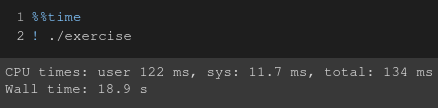



* Provide block/thread configurations that reduces the execution time. Compare the configurations and the execution time (for instance, with a table).

In [27]:
%%writefile configurations.cu

#include <iostream>
#include <math.h>
#include <stdio.h>
#define VALUE 20
#define PROBLEMSIZE 1000000000

__global__ void add(float *x, float *y, int size) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i < size)
      y[i] = x[i] + y[i];
}

int main(void) {
  float *x, *y;
  cudaMallocManaged(&x, PROBLEMSIZE * sizeof(float));
  cudaMallocManaged(&y, PROBLEMSIZE * sizeof(float));
  for (int i = 0; i < PROBLEMSIZE; i++) {
    float val = (float)(i % VALUE);
    x[i] = val;
    y[i] = (VALUE - val);
  }

  int configurations[][2] = {
    {256, 256},
    {512, 128},
    {1024, 64},
  };
  
  printf("Configuration\t|  Execution Time (ms)\n");
  printf("-------------------------------------\n");

  // Perform computations for each configuration and measure the execution time
  for (int config = 0, numConfigurations = sizeof(configurations) / sizeof(configurations[0]); config < numConfigurations; config++) {
    int blockSize = configurations[config][0];
    int numBlocks = (PROBLEMSIZE + blockSize - 1) / blockSize;

    // Start measuring execution time
    cudaEvent_t start, end;
    cudaEventCreate(&start);
    cudaEventCreate(&end);
    cudaEventRecord(start);

    add<<<numBlocks, blockSize>>>(x, y, PROBLEMSIZE);
    cudaDeviceSynchronize();

    // Stop measuring execution time
    cudaEventRecord(end);
    cudaEventSynchronize(end);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, end);

    // Print the configuration and its corresponding execution time
    printf("%d threads, %d blocks  | %.2f\n", blockSize, numBlocks, milliseconds);
  }

  cudaFree(x);
  cudaFree(y);
  return 0;
}


Overwriting configurations.cu


In [28]:
! nvcc -o configurations configurations.cu && ./configurations

Configuration	|  Execution Time (ms)
-------------------------------------
256 threads, 3906250 blocks  | 2034.24
512 threads, 1953125 blocks  | 46.67
1024 threads, 976563 blocks  | 46.72


* Is there any limitation on the blocks or threads quantities?

You can have up to 2^31 - 1 blocks in the x-dimension, and at most 65535 blocks in the y and z dimensions and a maximum of 1024 threads per block.

\* [CUDA C++ Programming Guide - 6.2. Features and Technical Specifications](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#features-and-technical-specifications)

## 6 Profiling

In [ ]:
! nvprof ./exercise

==28754== NVPROF is profiling process 28754, command: ./exercise
==28754== Profiling application: ./exercise
==28754== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  2.77920s         1  2.77920s  2.77920s  2.77920s  add(float*, float*, int)
      API calls:   77.21%  2.77921s         1  2.77921s  2.77921s  2.77921s  cudaDeviceSynchronize
                   15.92%  572.99ms         2  286.50ms  236.12ms  336.87ms  cudaFree
                    6.84%  246.17ms         2  123.09ms  51.124us  246.12ms  cudaMallocManaged
                    0.02%  889.17us         1  889.17us  889.17us  889.17us  cuDeviceGetPCIBusId
                    0.00%  113.31us       101  1.1210us     128ns  47.690us  cuDeviceGetAttribute
                    0.00%  63.917us         1  63.917us  63.917us  63.917us  cudaLaunchKernel
                    0.00%  23.675us         1  23.675us  23.675us  23.675us  cuDeviceGetName
                 

Provide the code of the non-managed CPU-GPU memory
version of the problem.

In [ ]:
%%writefile non_managed.cu

#include <iostream>
#include <math.h>
#define VALUE 20
#define PROBLEMSIZE 1000

__global__ void add(float *x, float *y, int size) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i < size)
        y[i] = x[i] + y[i];
}

int main(void) {
    float *x, *y;
    float *d_x, *d_y;
    int size = PROBLEMSIZE * sizeof(float);

    // Allocate memory on CPU
    x = (float*)malloc(size);
    y = (float*)malloc(size);

    // Initialize input arrays on CPU
    for (int i = 0; i < PROBLEMSIZE; i++) {
        float val = (float)(i % VALUE);
        x[i] = val;
        y[i] = (VALUE - val);
    }

    // Allocate memory on GPU
    cudaMalloc(&d_x, size);
    cudaMalloc(&d_y, size);

    // Copy input arrays from CPU to GPU
    cudaMemcpy(d_x, x, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_y, y, size, cudaMemcpyHostToDevice);

    // Launch kernel
    int blockSize = 1;
    int numBlocks = (PROBLEMSIZE + blockSize - 1) / blockSize;
    add<<<numBlocks, blockSize>>>(d_x, d_y, PROBLEMSIZE);
    cudaDeviceSynchronize();

    // Copy result array from GPU to CPU
    cudaMemcpy(y, d_y, size, cudaMemcpyDeviceToHost);

    // Check for errors
    float error = 0.0f;
    for (int i = 0; i < PROBLEMSIZE; i++)
        error = fmax(error, fabs(y[i] - VALUE));
    if (error != 0)
        printf("Wrong result. Check your code, especially your kernel\n");

    // Free memory on GPU
    cudaFree(d_x);
    cudaFree(d_y);

    // Free memory on CPU
    free(x);
    free(y);

    return 0;
}


Overwriting non_managed.cu


In [ ]:
! nvcc -o non_managed non_managed.cu && nvprof ./non_managed

==1322== NVPROF is profiling process 1322, command: ./non_managed
==1322== Profiling application: ./non_managed
==1322== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   55.64%  7.4240us         1  7.4240us  7.4240us  7.4240us  add(float*, float*, int)
                   27.09%  3.6150us         2  1.8070us  1.6960us  1.9190us  [CUDA memcpy HtoD]
                   17.27%  2.3040us         1  2.3040us  2.3040us  2.3040us  [CUDA memcpy DtoH]
      API calls:   99.66%  340.34ms         2  170.17ms  8.2480us  340.33ms  cudaMalloc
                    0.24%  804.43us         1  804.43us  804.43us  804.43us  cuDeviceGetPCIBusId
                    0.04%  125.67us       101  1.2440us     142ns  52.676us  cuDeviceGetAttribute
                    0.03%  102.13us         2  51.063us  6.3910us  95.735us  cudaFree
                    0.02%  61.743us         3  20.581us  9.3790us  28.301us  cudaMemcpy
                    0.01%  3

* Which are the dominant API calls when the block size is equal to "1"? Why?

`cudaMalloc` with accounts for 99.66% of the API calls. The majority of the time is spent on allocating GPU memory because the block size. With a small block size, more individual memory allocations are required leading to that increased overhead.



* Would the dominant API calls be the same in the managed memory version? Why?

In [ ]:
! nvcc -o managed exercise.cu && nvprof ./managed

==2678== NVPROF is profiling process 2678, command: ./managed
==2678== Profiling application: ./managed
==2678== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  3.56911s         1  3.56911s  3.56911s  3.56911s  add(float*, float*, int)
      API calls:   81.99%  3.56914s         1  3.56914s  3.56914s  3.56914s  cudaDeviceSynchronize
                   12.17%  530.02ms         2  265.01ms  235.74ms  294.28ms  cudaFree
                    5.83%  254.02ms         2  127.01ms  58.169us  253.96ms  cudaMallocManaged
                    0.00%  118.48us       101  1.1730us     131ns  48.039us  cuDeviceGetAttribute
                    0.00%  74.836us         1  74.836us  74.836us  74.836us  cudaLaunchKernel
                    0.00%  25.015us         1  25.015us  25.015us  25.015us  cuDeviceGetName
                    0.00%  7.3720us         1  7.3720us  7.3720us  7.3720us  cuDeviceGetPCIBusId
                    0.0

This time the dominants APIs are:

* cudaDeviceSynchronize (81.99%): the majority of the time  of this code is spent waiting for the kernel to finish its execution since it is the primary computation in this code.

* cudaFree (12.17%) and cudaMallocManaged (5.83%) because large amount of memory is being allocated.